In [1]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

### HRP code from the paper (Lopez de Prada 2016)

You can run it with run_hrp_artificial_data() and play with artificially generated data parameters to get intuition about how HRP works.

Also contains slightly modified clean_covariance_matrix() from part 2 and function build_hrp which takes in real data.

In [ ]:
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp


def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters

        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = pd.concat([sortIx, df0]).sort_index()  # concatenate instead of append
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx, dtype=float)
    cItems=[sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems=[elem[j:k] for elem in cItems for j,k in \
                ((0,len(elem)//2), (len(elem)//2,len(elem))) if len(elem)>1] # bi-section
        # print("humus", len(cItems), cItems)
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0=cItems[i] # cluster 1
            cItems1=cItems[i+1] # cluster 2
            cVar0=getClusterVar(cov,cItems0)
            cVar1=getClusterVar(cov,cItems1)
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1
            w[cItems1]*=1-alpha # weight 2
    return w

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist


def plotCorrMatrix(path,corr,labels=None):
    # Heatmap of the correlation matrix
    if labels is None:labels=[]
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.savefig(path)
    mpl.clf();mpl.close() # reset pylab
    return

def generateData(nObs,size0,size1,sigma1):
    # Time series of correlated variables
    #1) generating some uncorrelated data
    np.random.seed(seed=12345);random.seed(12345)
    x=np.random.normal(0,1,size=(nObs,size0)) # each row is a variable
    #2) creating correlation between the variables
    cols=[random.randint(0,size0-1) for i in range(size1)]
    y=x[:,cols]+np.random.normal(0,sigma1,size=(nObs,len(cols)))
    x=np.append(x,y,axis=1)
    x=pd.DataFrame(x,columns=range(1,x.shape[1]+1))
    print(x.shape)
    return x,cols

def run_hrp_artificial_data():
    #1) Generate correlated data
    nObs,size0,size1,sigma1=250,5,5,.25
    x,cols=generateData(nObs,size0,size1,sigma1) # x is of size 10000 by 10 (250 by 14?)
    print([(j+1,size0+i) for i,j in enumerate(cols,1)])
    
    #2) compute and plot correl matrix
    cov,corr=x.cov(),x.corr()
    # plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
    
    # 3) cluster
    dist=correlDist(corr)
    condensed_dist_matrix = squareform(dist)
    link=sch.linkage(condensed_dist_matrix,'single')
    fig = plt.figure(figsize=(25, 10))
    dn = sch.dendrogram(link)
    plt.show()
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels
    df0=corr.loc[sortIx,sortIx] # reorder
    # plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx)
    print(hrp)


def clean_covariance_matrix(cov_matrix: pd.DataFrame, clip_threshold=1e-4):
    # Eigen decomposition (values and vectors as NumPy arrays)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix.values)

    # Clip small eigenvalues
    eigvals = np.clip(eigvals, clip_threshold, None)

    # Reconstruct the cleaned covariance matrix
    cleaned_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # Return as a DataFrame with original index/columns
    cleaned_df = pd.DataFrame(cleaned_matrix, index=cov_matrix.index, columns=cov_matrix.columns)

    return cleaned_df

def build_hrp(data, clean_cov_matrix=False):
    #1) compute and plot correl matrix
    cov,corr=data.cov(),data.corr()

    #2) clean covariance matrix (eigen clipping)
    if clean_cov_matrix:
        cov = clean_covariance_matrix(cov)
    # plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)

    # 3) cluster
    dist=correlDist(corr)
    condensed_dist_matrix = squareform(dist) 
    link=sch.linkage(condensed_dist_matrix,'single')
    fig = plt.figure(figsize=(25, 10))
    dn = sch.dendrogram(link)
    plt.show()
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels
    df0=corr.loc[sortIx,sortIx] # reorder
    # plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx)
    return hrp


(250, 10)
[(4, 6), (1, 7), (3, 8), (3, 9), (2, 10)]


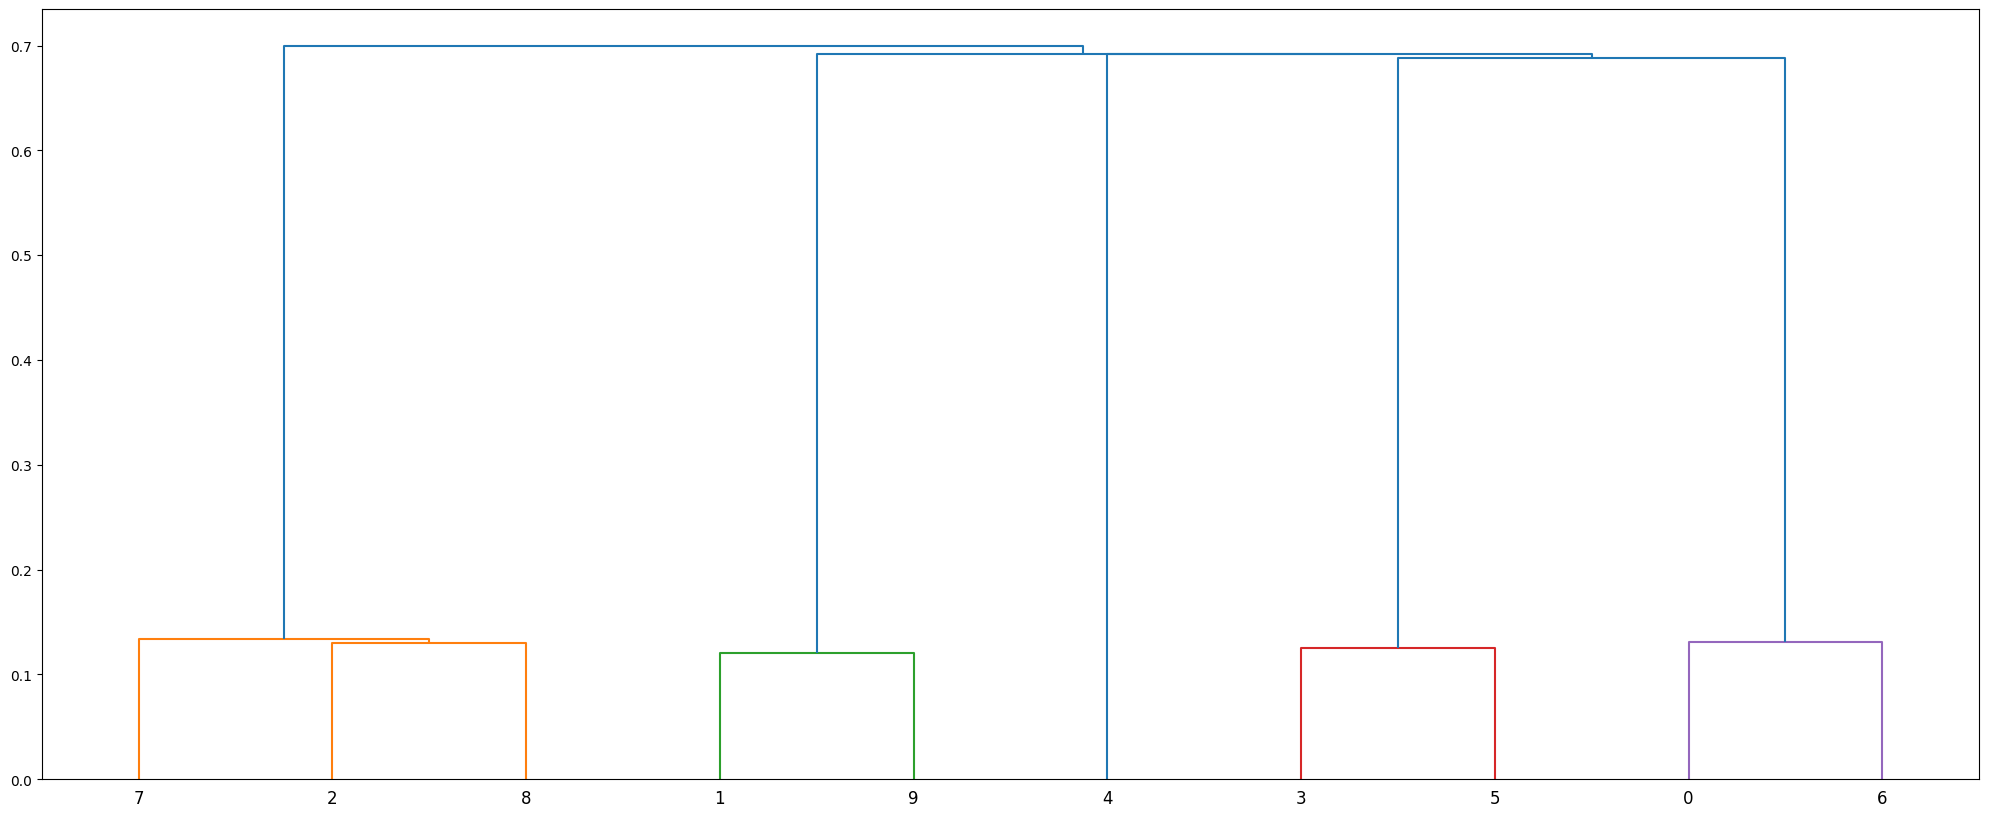

8     0.071549
3     0.075943
9     0.132707
2     0.062382
10    0.060744
5     0.188556
4     0.140235
6     0.122260
1     0.074824
7     0.070800
dtype: float64


In [5]:
run_hrp_artificial_data()

### Load our data
Preprocess it as you wish (e.g. excluding weekdays)

In [ ]:
prices = pd.read_csv('./fin413_data.csv', sep=';')

prices['Date'] = pd.to_datetime(prices['Date'], format='%d.%m.%Y')
prices.set_index('Date', inplace=True)
print("All prices", prices.shape)

datePP = '2021-09-11'
dateTr = '2022-11-21'

weekdays_only = prices[prices.index.weekday < 5]
print("weekday prices", weekdays_only.shape)


log_returns = np.log(weekdays_only / weekdays_only.shift(1)).dropna()


window_size = 250

window_pp = log_returns.loc[:datePP].iloc[-window_size:]
window_tr = log_returns.loc[:dateTr].iloc[-window_size:]

print("Window of log returns data", window_pp.shape)


Run HRP foro datePP and dateTR

In [ ]:
# excluded = ['SOFR', 'XCMP', 'SPXT', 'VIX']
excluded = []
df_filtered = window_pp.drop(columns=excluded)

hrp = build_hrp(df_filtered, clean_cov_matrix=True)
print(hrp)

In [ ]:
df_filtered = window_tr.drop(columns=excluded)

hrp = build_hrp(df_filtered, clean_cov_matrix=True)
print(hrp)